In [1]:
import pandas as pd
import numpy as np
import plotnine as p9
import matplotlib.pyplot as plt

from sklearn.pipeline import Pipeline
from sklearn.compose import make_column_selector, ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, PolynomialFeatures
from sklearn.linear_model import LinearRegression, LogisticRegression, Ridge, Lasso,ElasticNet
from sklearn.neighbors import KNeighborsRegressor, KNeighborsClassifier
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, KFold
from sklearn.metrics import r2_score, classification_report, accuracy_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc
from sklearn.metrics import  precision_score, recall_score, roc_auc_score, cohen_kappa_score
from sklearn.metrics._regression import mean_squared_error
from sklearn.feature_selection import SelectFromModel
from sklearn.tree import DecisionTreeClassifier, plot_tree, DecisionTreeRegressor
from sklearn.inspection import permutation_importance
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.svm import SVC
from sklearn.multiclass import OneVsRestClassifier, OneVsOneClassifier

## Part Zero: Data set up and Exploration

### 1. Data Exploration

In [2]:
CAH_Train = pd.read_csv(r"C:\Users\ldcal\OneDrive\Desktop\Cal Poly Courses\Fall\GSB-S544\Coding Work\Pyython_Work\Kaggle_Comp\Kaggle_Class\CAH-201803-train.csv")
CAH_Test = pd.read_csv(r"C:\Users\ldcal\OneDrive\Desktop\Cal Poly Courses\Fall\GSB-S544\Coding Work\Pyython_Work\Kaggle_Comp\Kaggle_Class\CAH-201803-test.csv")

In [3]:
def show_unique_cats(df, max_unique=20):
    for col in df.columns:
        nunique = df[col].nunique(dropna=True)
        if nunique <= max_unique:
            print(f"Column: {col}  (unique values: {nunique})")
            print(df[col].unique())
            print("-" * 40)

In [4]:
show_unique_cats(CAH_Train.iloc[:,:10], max_unique=10)

Column: Q1  (unique values: 2)
['Male' 'Female']
----------------------------------------
Column: political_affiliation  (unique values: 3)
['Independent' 'Democrat' 'Republican']
----------------------------------------
Column: Q4  (unique values: 3)
['Liberal' 'Conservative' 'Moderate']
----------------------------------------
Column: Q5  (unique values: 4)
['College degree' 'Some college' 'High school or less' 'Graduate degree']
----------------------------------------
Column: Q6  (unique values: 4)
['Black' 'White' 'Latino' 'Asian']
----------------------------------------
Column: Q7  (unique values: 2)
['No' 'Yes']
----------------------------------------
Column: Q8  (unique values: 2)
['No' 'Yes']
----------------------------------------
Column: Q9  (unique values: 2)
['No' 'Yes']
----------------------------------------


In [5]:
show_unique_cats(CAH_Train.iloc[:, -9:], max_unique=10)

Column: Q10  (unique values: 3)
['Yes, somewhat religious' 'Yes, very religious' 'No']
----------------------------------------
Column: Q11  (unique values: 2)
['Pro-Choice' 'Pro-life']
----------------------------------------
Column: Q12  (unique values: 2)
['No' 'Yes']
----------------------------------------
Column: Q13  (unique values: 2)
['No' 'Yes']
----------------------------------------
Column: Q14  (unique values: 3)
['Behave no differently' 'Less Willing' 'More Willing']
----------------------------------------
Column: Q15  (unique values: 4)
[5 4 1 2]
----------------------------------------
Column: Q16  (unique values: 4)
[2 5 1 4]
----------------------------------------
Column: Q17  (unique values: 4)
[5 4 1 2]
----------------------------------------
Column: Q18  (unique values: 2)
['No' 'Yes']
----------------------------------------


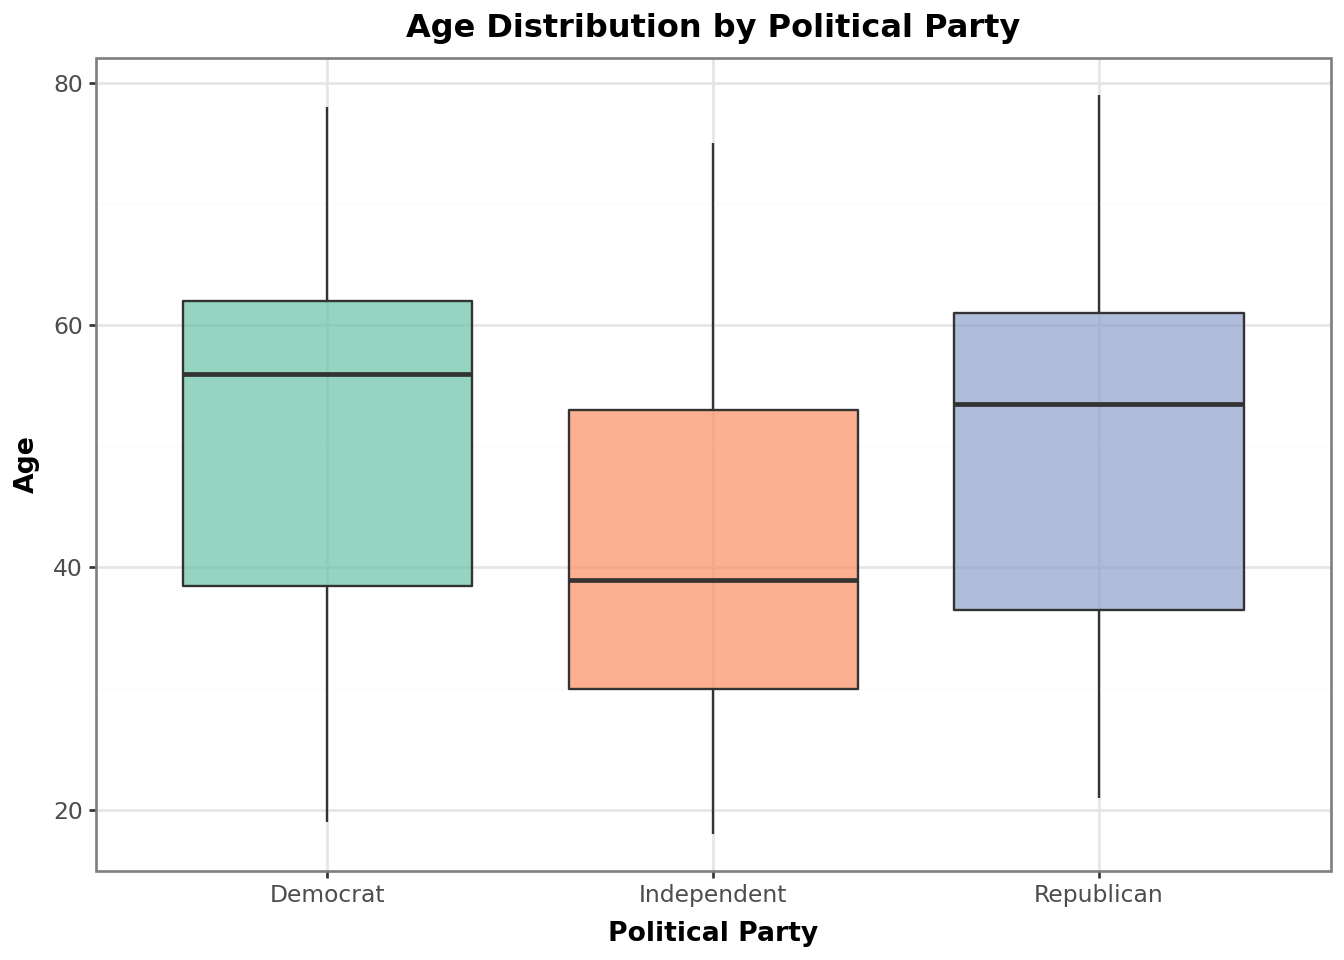

In [6]:
(p9.ggplot(CAH_Train, p9.aes(x = "political_affiliation", y ="Q2", fill = "political_affiliation" ))
+ p9.geom_boxplot(alpha=0.7)
+p9.scale_fill_brewer(type="qual", palette="Set2")    
+ p9.theme_bw()
+ p9.labs(
        title="Age Distribution by Political Party",
        x="Political Party",
        y="Age"
    )
+ p9.theme(legend_position = "none",
            axis_text_x=p9.element_text(rotation=0, ha="center"),
            plot_title=p9.element_text(ha="center", size=12, weight="bold"),
            axis_title_x=p9.element_text(size=10, weight="bold"),
            axis_title_y=p9.element_text(size=10, weight="bold"),
            )
)

Looking at the dataset we can see that age doesnt show to much predictive power so using the varaible may not be too inportant towards our models, i suspect that using a tree model will be very powerfull as this can use all of the true or false questions given to help affilate a political part with a specific person. 

In [7]:
CAH_Train.isna().sum().sort_values(ascending=False)

id_num                   0
Q1                       0
Q2                       0
political_affiliation    0
Q4                       0
Q5                       0
Q6                       0
Q7                       0
Q8                       0
Q9                       0
Q10                      0
Q11                      0
Q12                      0
Q13                      0
Q14                      0
Q15                      0
Q16                      0
Q17                      0
Q18                      0
dtype: int64

### 2. Column Transformer

In [8]:
cat_selector = make_column_selector(dtype_include=["object", "category"])
num_selector = make_column_selector(dtype_include=["int64", "float64"])

ct = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(handle_unknown="ignore"), cat_selector),
        ("num", StandardScaler(), num_selector),
    ],
    remainder="drop"
)

### 3. Pipeline Testers Functions 

In [9]:
def Build_and_Test_Pipeline (pipeline_name,params,
                             model_name, model_sklearn, X, y):

    pipeline_name = Pipeline(
       [("preprocessing", ct),
        (model_name, model_sklearn)]
    )   

    grid = GridSearchCV(pipeline_name, params, cv = 5, scoring = "accuracy")
    fit = grid.fit(X, y)
    print(pd.DataFrame(fit.cv_results_)[["params", "mean_test_score"]])
    return (fit.best_params_)


def Final_Fit_and_Acc (pipeline_name, model_name, model_sklearn, X_training,
                         y_training, X_test, y_test, data):
    
    pipeline_name = Pipeline(
     [("preprocessing", ct),
        (model_name, model_sklearn)]
    )

    pipeline_name.fit(X_training, y_training)
    pred = pipeline_name.predict(X_test)
    acc = accuracy_score(y_test, pred)

    plot1 = ConfusionMatrixDisplay(confusion_matrix(y_test, pred), 
                                    display_labels=['Democrat', 'Independent', 'Republican'])
    plot1.plot(cmap="bwr")
    plt.show

    data.append({"Model Name" : model_name, 
                        "accuracy" : acc})
    return(acc)

## Part One: Modeling Using All the Data

### 0. Data Preperation and Training 

In [10]:
CAH_Train_NID = CAH_Train.drop("id_num", axis = 1)

X1 = CAH_Train_NID.drop("political_affiliation", axis = 1)
y1 = CAH_Train_NID["political_affiliation"]

Part1_Results = []

In [11]:
X_train1, X_valid1, y_train1, y_valid1 =  train_test_split(X1, y1, test_size=0.25, random_state=42)

### 1. Logistic Regression

In [12]:
param_grid_log1 = {"Log__C": [0.1, .2, .3, .4, .5, .75, 1.0], 
                  "Log__solver": ["lbfgs"],
                  "Log__penalty": ["l2"],
                  "Log__max_iter": [1000]}

Build_and_Test_Pipeline("Logistic_pipe", param_grid_log1, "Log", LogisticRegression(), X_train1, y_train1)

                                              params  mean_test_score
0  {'Log__C': 0.1, 'Log__max_iter': 1000, 'Log__p...         0.618769
1  {'Log__C': 0.2, 'Log__max_iter': 1000, 'Log__p...         0.602462
2  {'Log__C': 0.3, 'Log__max_iter': 1000, 'Log__p...         0.610462
3  {'Log__C': 0.4, 'Log__max_iter': 1000, 'Log__p...         0.618462
4  {'Log__C': 0.5, 'Log__max_iter': 1000, 'Log__p...         0.618462
5  {'Log__C': 0.75, 'Log__max_iter': 1000, 'Log__...         0.610462
6  {'Log__C': 1.0, 'Log__max_iter': 1000, 'Log__p...         0.610462


{'Log__C': 0.1,
 'Log__max_iter': 1000,
 'Log__penalty': 'l2',
 'Log__solver': 'lbfgs'}

0.6046511627906976

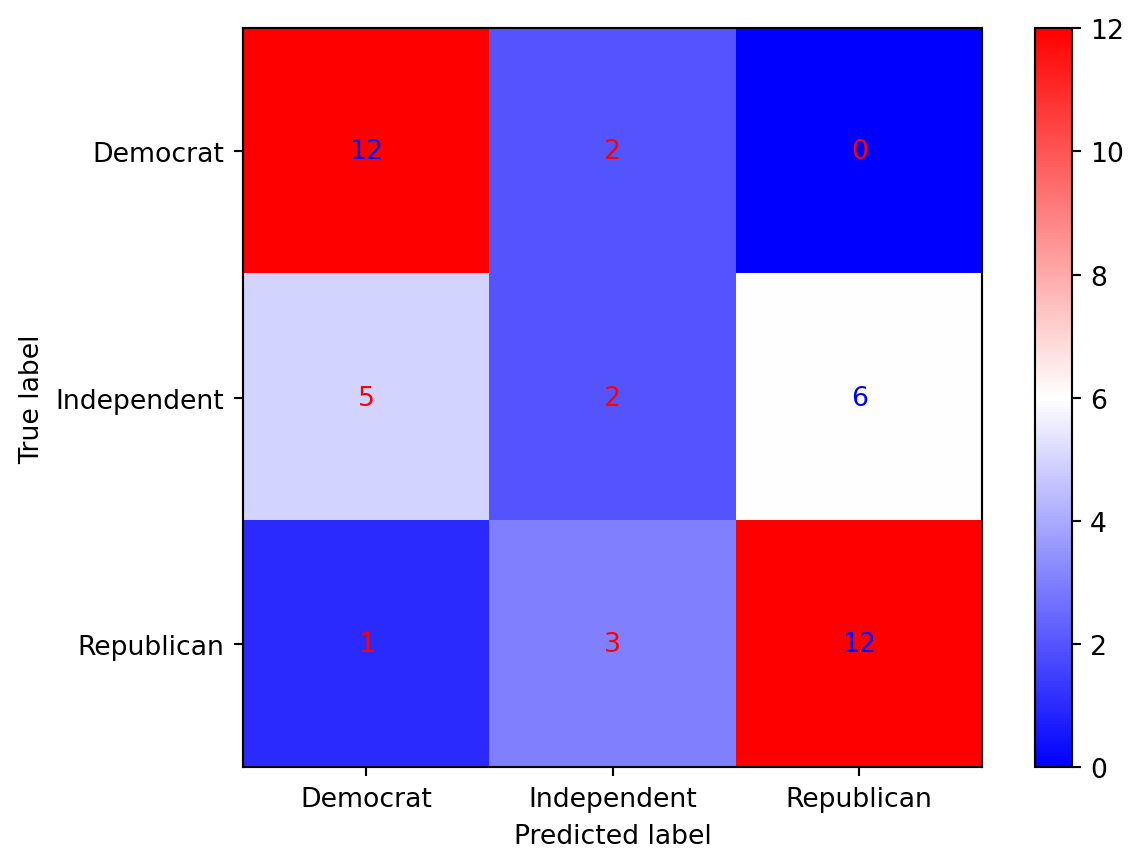

In [13]:
Final_Fit_and_Acc("Final_Log", "Log", LogisticRegression(
    C = 0.1,
    max_iter = 1000,
    penalty= "l2", 
    solver = "lbfgs"
), X_train1, y_train1, X_valid1, y_valid1, Part1_Results)

### 2. LDA

In [14]:
param_grid_LDA1 = {
        "LDA__solver": ["svd"],
        "LDA__tol": [1e-4, 1e-3, 1e-2],
        "LDA__n_components": [1, 2],
    }

Build_and_Test_Pipeline("LDA_pipe", param_grid_LDA1, "LDA", LinearDiscriminantAnalysis(), X_train1, y_train1)

                                              params  mean_test_score
0  {'LDA__n_components': 1, 'LDA__solver': 'svd',...         0.579077
1  {'LDA__n_components': 1, 'LDA__solver': 'svd',...         0.579077
2  {'LDA__n_components': 1, 'LDA__solver': 'svd',...         0.579077
3  {'LDA__n_components': 2, 'LDA__solver': 'svd',...         0.579077
4  {'LDA__n_components': 2, 'LDA__solver': 'svd',...         0.579077
5  {'LDA__n_components': 2, 'LDA__solver': 'svd',...         0.579077


{'LDA__n_components': 1, 'LDA__solver': 'svd', 'LDA__tol': 0.0001}

0.5813953488372093

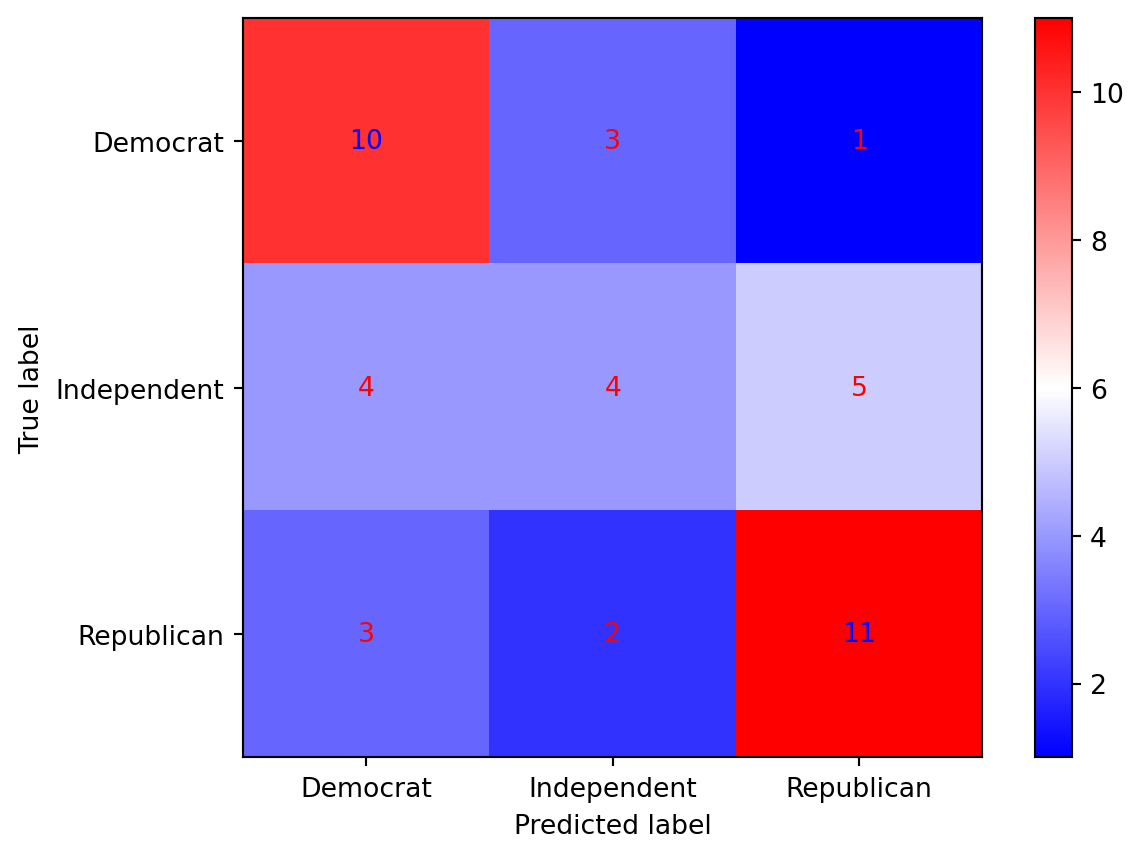

In [15]:
Final_Fit_and_Acc("LDA_final", "LDA",LinearDiscriminantAnalysis(n_components=1,
                                                                solver="svd", 
                                                                tol = 0.0001), 
                X_train1, y_train1, X_valid1, y_valid1, Part1_Results)

### 3. QDA

In [16]:
param_grid_QDA1 = {
    "QDA__reg_param": [0.1, 0.3, 0.5, 0.7, 0.9, 1.0],
    "QDA__tol": [1e-4, 1e-3],
}

Build_and_Test_Pipeline("QDA_pipe", param_grid_QDA1, "QDA", QuadraticDiscriminantAnalysis(), X_train1, y_train1)

C:\Users\ldcal\anaconda3\Lib\site-packages\sklearn\discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 0 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
C:\Users\ldcal\anaconda3\Lib\site-packages\sklearn\discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 1 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
C:\Users\ldcal\anaconda3\Lib\site-packages\sklearn\discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 2 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
C:\Users\ldcal\anaconda3\Lib\site-packages\sklearn\discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 0 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
C:\Users\ldcal\anaconda3\Lib\site-packages\sklearn\discriminant_analysis

C:\Users\ldcal\anaconda3\Lib\site-packages\sklearn\discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 2 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
C:\Users\ldcal\anaconda3\Lib\site-packages\sklearn\discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 0 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
C:\Users\ldcal\anaconda3\Lib\site-packages\sklearn\discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 1 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
C:\Users\ldcal\anaconda3\Lib\site-packages\sklearn\discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 2 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
C:\Users\ldcal\anaconda3\Lib\site-packages\sklearn\discriminant_analysis

C:\Users\ldcal\anaconda3\Lib\site-packages\sklearn\discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 0 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
C:\Users\ldcal\anaconda3\Lib\site-packages\sklearn\discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 1 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
C:\Users\ldcal\anaconda3\Lib\site-packages\sklearn\discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 2 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
C:\Users\ldcal\anaconda3\Lib\site-packages\sklearn\discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 0 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
C:\Users\ldcal\anaconda3\Lib\site-packages\sklearn\discriminant_analysis

C:\Users\ldcal\anaconda3\Lib\site-packages\sklearn\discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 0 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
C:\Users\ldcal\anaconda3\Lib\site-packages\sklearn\discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 1 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
C:\Users\ldcal\anaconda3\Lib\site-packages\sklearn\discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 2 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
C:\Users\ldcal\anaconda3\Lib\site-packages\sklearn\discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 0 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
C:\Users\ldcal\anaconda3\Lib\site-packages\sklearn\discriminant_analysis

C:\Users\ldcal\anaconda3\Lib\site-packages\sklearn\discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 0 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
C:\Users\ldcal\anaconda3\Lib\site-packages\sklearn\discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 1 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
C:\Users\ldcal\anaconda3\Lib\site-packages\sklearn\discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 2 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
C:\Users\ldcal\anaconda3\Lib\site-packages\sklearn\discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 0 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
C:\Users\ldcal\anaconda3\Lib\site-packages\sklearn\discriminant_analysis

C:\Users\ldcal\anaconda3\Lib\site-packages\sklearn\discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 0 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
C:\Users\ldcal\anaconda3\Lib\site-packages\sklearn\discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 1 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
C:\Users\ldcal\anaconda3\Lib\site-packages\sklearn\discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 2 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
C:\Users\ldcal\anaconda3\Lib\site-packages\sklearn\discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 0 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
C:\Users\ldcal\anaconda3\Lib\site-packages\sklearn\discriminant_analysis

C:\Users\ldcal\anaconda3\Lib\site-packages\sklearn\discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 0 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
C:\Users\ldcal\anaconda3\Lib\site-packages\sklearn\discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 1 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
C:\Users\ldcal\anaconda3\Lib\site-packages\sklearn\discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 2 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
C:\Users\ldcal\anaconda3\Lib\site-packages\sklearn\discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 0 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
C:\Users\ldcal\anaconda3\Lib\site-packages\sklearn\discriminant_analysis

                                         params  mean_test_score
0   {'QDA__reg_param': 0.1, 'QDA__tol': 0.0001}         0.469231
1    {'QDA__reg_param': 0.1, 'QDA__tol': 0.001}         0.469231
2   {'QDA__reg_param': 0.3, 'QDA__tol': 0.0001}         0.468923
3    {'QDA__reg_param': 0.3, 'QDA__tol': 0.001}         0.468923
4   {'QDA__reg_param': 0.5, 'QDA__tol': 0.0001}         0.508923
5    {'QDA__reg_param': 0.5, 'QDA__tol': 0.001}         0.508923
6   {'QDA__reg_param': 0.7, 'QDA__tol': 0.0001}         0.548000
7    {'QDA__reg_param': 0.7, 'QDA__tol': 0.001}         0.548000
8   {'QDA__reg_param': 0.9, 'QDA__tol': 0.0001}         0.563385
9    {'QDA__reg_param': 0.9, 'QDA__tol': 0.001}         0.563385
10  {'QDA__reg_param': 1.0, 'QDA__tol': 0.0001}         0.555385
11   {'QDA__reg_param': 1.0, 'QDA__tol': 0.001}         0.555385


C:\Users\ldcal\anaconda3\Lib\site-packages\sklearn\discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 0 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
C:\Users\ldcal\anaconda3\Lib\site-packages\sklearn\discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 1 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
C:\Users\ldcal\anaconda3\Lib\site-packages\sklearn\discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 2 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
C:\Users\ldcal\anaconda3\Lib\site-packages\sklearn\discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 0 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
C:\Users\ldcal\anaconda3\Lib\site-packages\sklearn\discriminant_analysis

{'QDA__reg_param': 0.9, 'QDA__tol': 0.0001}

0.5348837209302325

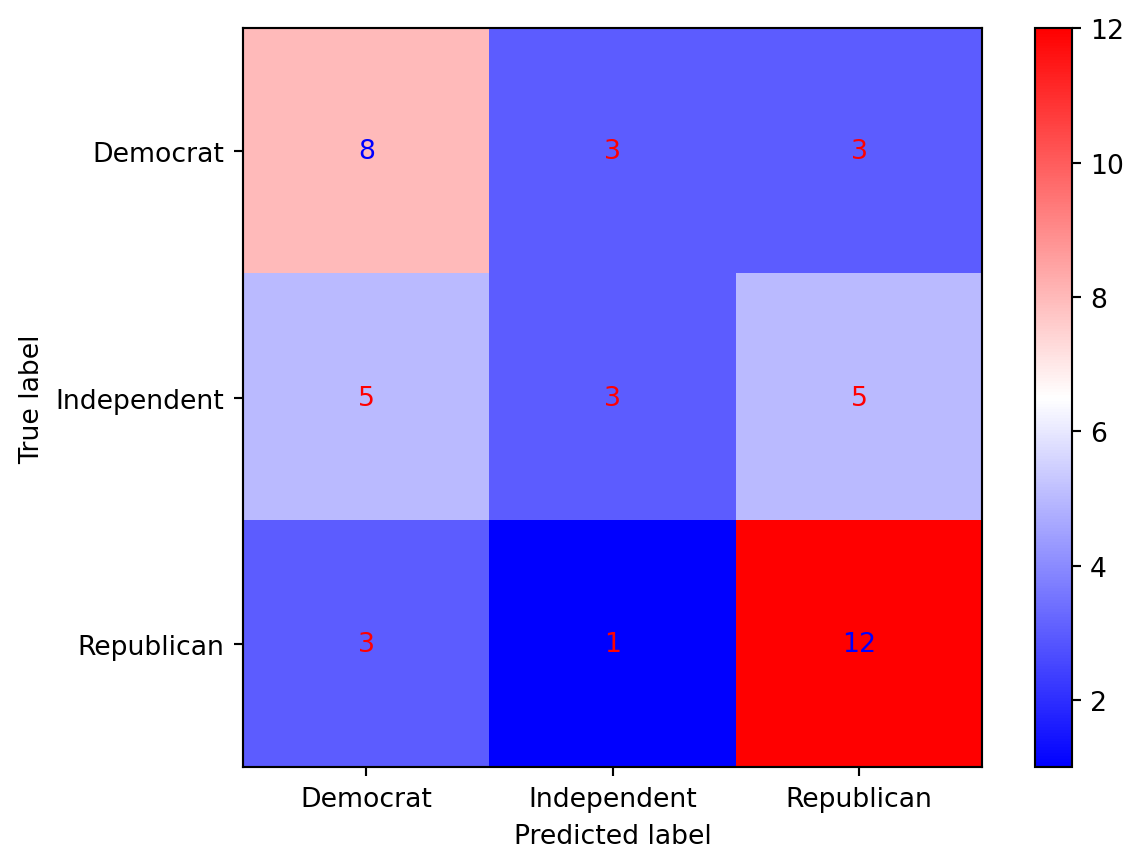

In [17]:
Final_Fit_and_Acc("Final_QDA", "QDA", QuadraticDiscriminantAnalysis(reg_param=0.9,
                                                                    tol=0.0001),
                X_train1, y_train1, X_valid1, y_valid1, Part1_Results)

### 4. Linear SVM 

In [18]:
param_grid_svc1 = {
        "SVC__kernel": ["linear"],
        "SVC__C": [0.05, 0.075,0.09, 0.092,0.095, 0.1]}

Build_and_Test_Pipeline("SVM_pipe", param_grid_svc1, "SVC", SVC(), X_train1, y_train1)

                                       params  mean_test_score
0   {'SVC__C': 0.05, 'SVC__kernel': 'linear'}         0.626462
1  {'SVC__C': 0.075, 'SVC__kernel': 'linear'}         0.626769
2   {'SVC__C': 0.09, 'SVC__kernel': 'linear'}         0.642769
3  {'SVC__C': 0.092, 'SVC__kernel': 'linear'}         0.642769
4  {'SVC__C': 0.095, 'SVC__kernel': 'linear'}         0.634769
5    {'SVC__C': 0.1, 'SVC__kernel': 'linear'}         0.634769


{'SVC__C': 0.09, 'SVC__kernel': 'linear'}

0.5813953488372093

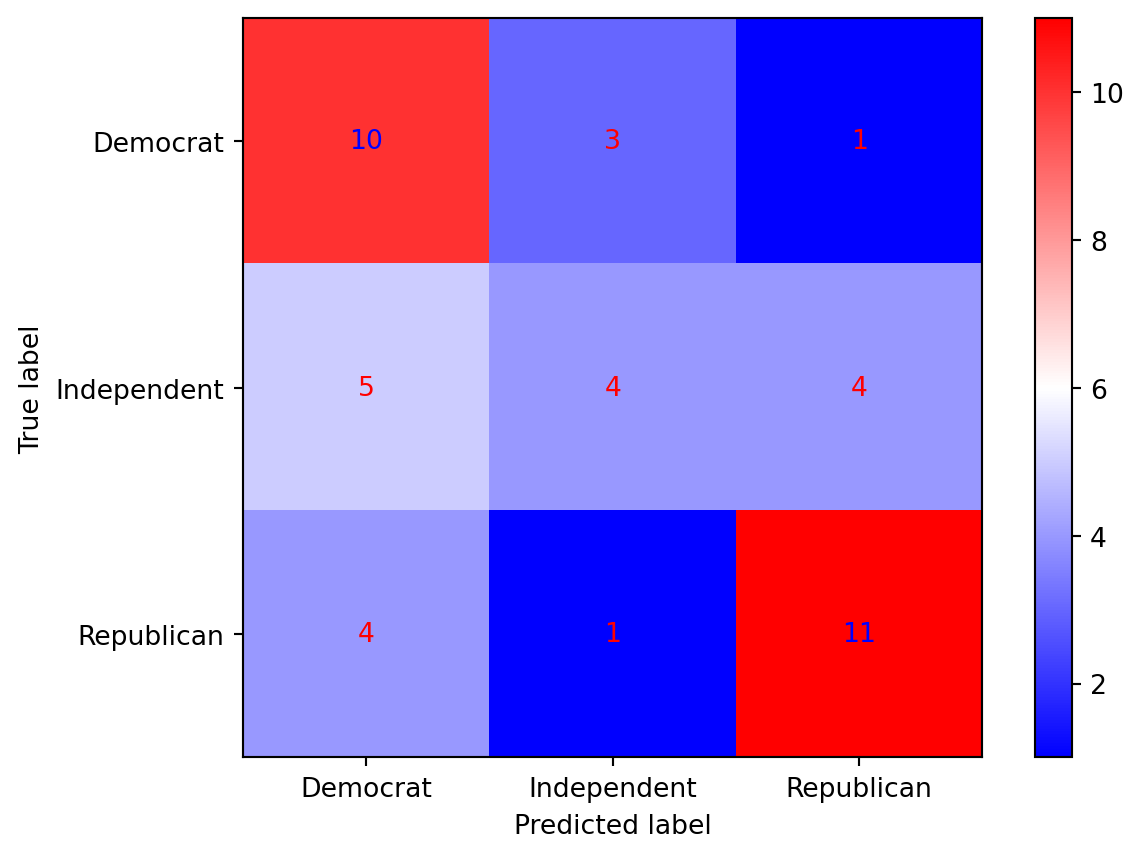

In [19]:
Final_Fit_and_Acc("Final_SVM", "SVC", SVC(C = 0.09, kernel="linear"), 
                    X_train1, y_train1, X_valid1, y_valid1, Part1_Results)

### 5. KNN

In [20]:
param_grid_knn1 = {
    "KNN__n_neighbors":[8, 9, 10, 11]}

Build_and_Test_Pipeline("KNN_pipe", param_grid_knn1, "KNN", KNeighborsClassifier(), X_train1, y_train1)

                     params  mean_test_score
0   {'KNN__n_neighbors': 8}         0.492923
1   {'KNN__n_neighbors': 9}         0.540308
2  {'KNN__n_neighbors': 10}         0.524308
3  {'KNN__n_neighbors': 11}         0.500000


{'KNN__n_neighbors': 9}

0.5348837209302325

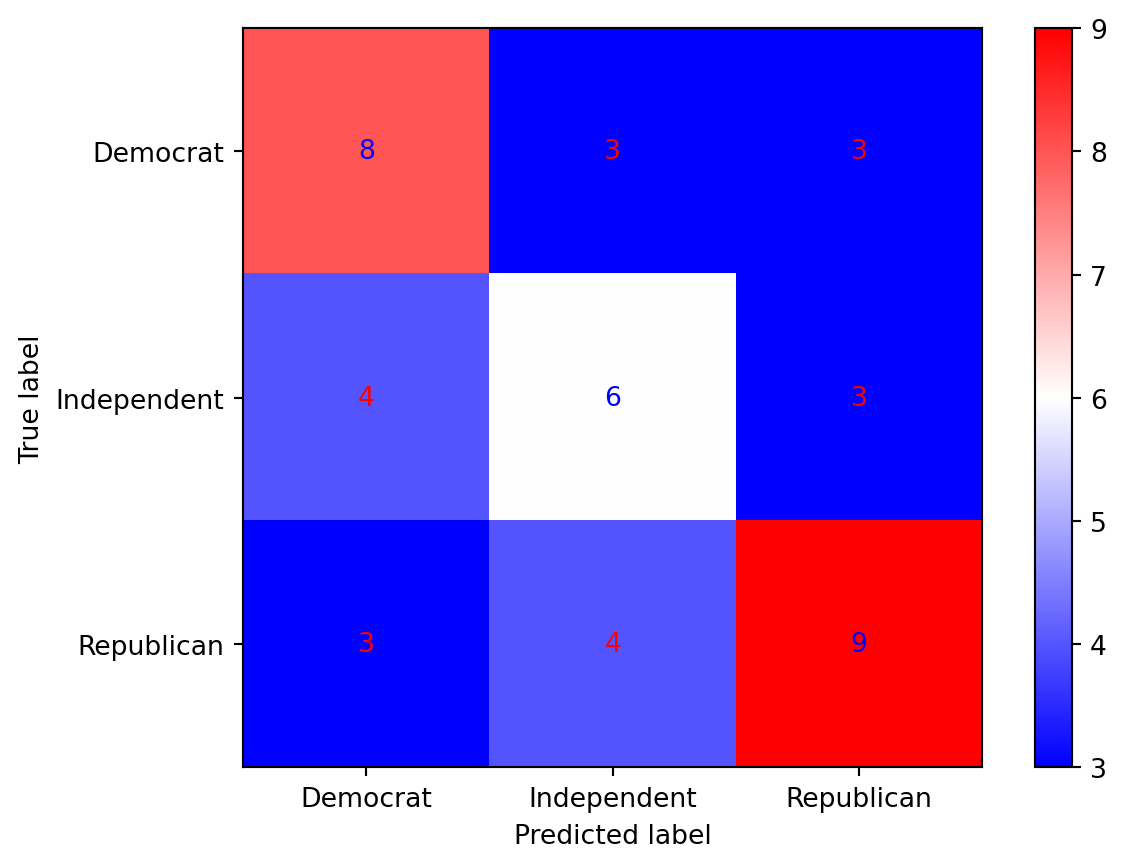

In [21]:
Final_Fit_and_Acc("Final_Knn", "KNN", KNeighborsClassifier(n_neighbors=9), X_train1, y_train1,
X_valid1, y_valid1, Part1_Results)

### 6. Decision Trees

In [22]:
param_grid_Tree1 = {
    "Tree__max_depth": [None, 3, 5, 8, 12],
    "Tree__min_samples_split": [2, 5, 10, 20],
    "Tree__min_samples_leaf": [1, 2, 5, 10],
    "Tree__splitter": ["best", "random"],
    "Tree__ccp_alpha": [0.0, 0.0005, 0.001, 0.005]  
}

Build_and_Test_Pipeline("Tree_pipe", param_grid_Tree1, "Tree", DecisionTreeClassifier(), X_train1, y_train1)

                                                params  mean_test_score
0    {'Tree__ccp_alpha': 0.0, 'Tree__max_depth': No...         0.499692
1    {'Tree__ccp_alpha': 0.0, 'Tree__max_depth': No...         0.475692
2    {'Tree__ccp_alpha': 0.0, 'Tree__max_depth': No...         0.524308
3    {'Tree__ccp_alpha': 0.0, 'Tree__max_depth': No...         0.539385
4    {'Tree__ccp_alpha': 0.0, 'Tree__max_depth': No...         0.516000
..                                                 ...              ...
635  {'Tree__ccp_alpha': 0.005, 'Tree__max_depth': ...         0.548000
636  {'Tree__ccp_alpha': 0.005, 'Tree__max_depth': ...         0.539692
637  {'Tree__ccp_alpha': 0.005, 'Tree__max_depth': ...         0.555385
638  {'Tree__ccp_alpha': 0.005, 'Tree__max_depth': ...         0.571692
639  {'Tree__ccp_alpha': 0.005, 'Tree__max_depth': ...         0.516000

[640 rows x 2 columns]


{'Tree__ccp_alpha': 0.0005,
 'Tree__max_depth': 5,
 'Tree__min_samples_leaf': 10,
 'Tree__min_samples_split': 20,
 'Tree__splitter': 'random'}

0.5348837209302325

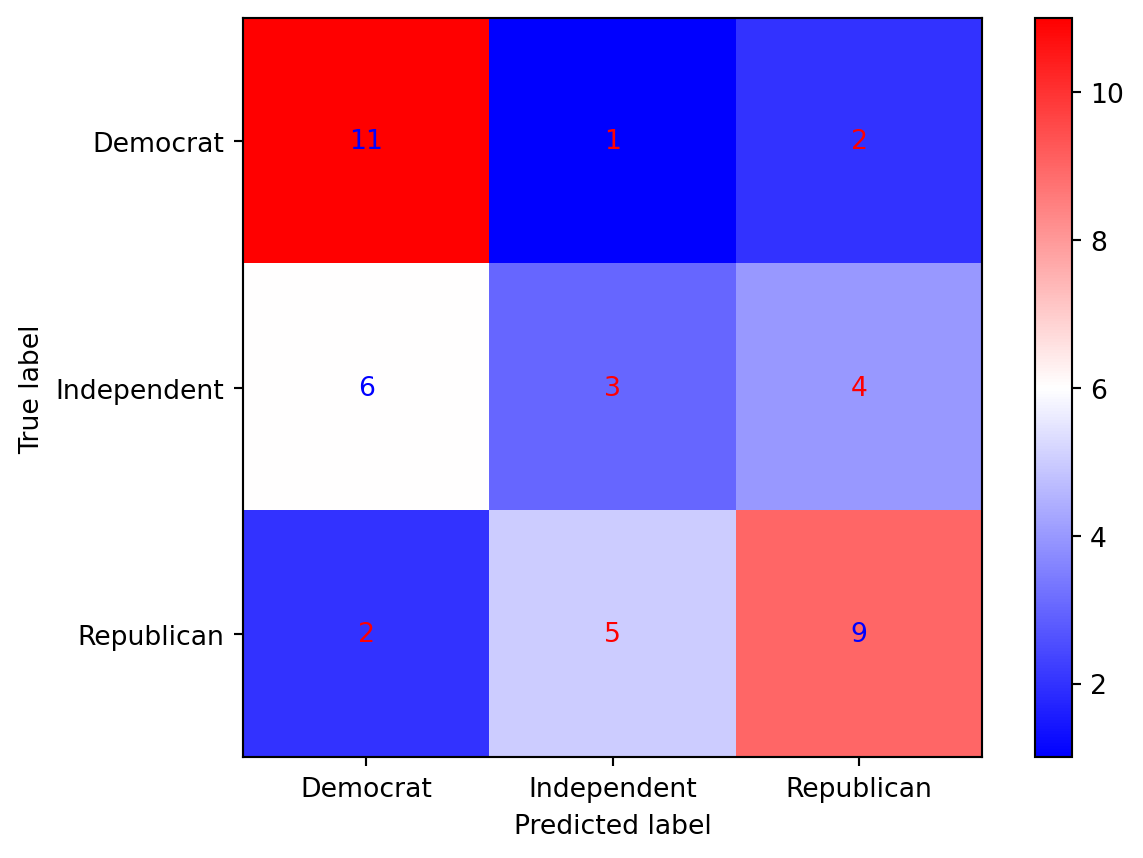

In [23]:
Final_Fit_and_Acc("Final_Tree", "Tree", DecisionTreeClassifier(ccp_alpha=0.005, 
                                                                max_depth=8,
                                                                min_samples_leaf=1,
                                                                min_samples_split=20,
                                                                splitter="random"),
                    X_train1, y_train1, X_valid1, y_valid1, Part1_Results)

### 7. Results 

In [24]:
df1 = pd.DataFrame(Part1_Results)
df1["Data"] = "General"
df1

,Model Name,accuracy,Data
0,Log,0.604651,General
1,LDA,0.581395,General
2,QDA,0.534884,General
3,SVC,0.581395,General
4,KNN,0.534884,General
5,Tree,0.534884,General


## Part Two: OVR

In [25]:
Part2_Results = []

### 1. Logistic Regression

In [26]:
param_grid_ovr1 = {
    "OVR__estimator__C": [0.14, 0.15, 0.17, 0.2 , 0.25, 0.5],
    "OVR__estimator__penalty": ["l2"],
    "OVR__estimator__solver": ["lbfgs"],  # good default for multi-class
}

Build_and_Test_Pipeline("OVR_Log_pipe", param_grid_ovr1, "OVR",OneVsRestClassifier(LogisticRegression()),
 X_train1, y_train1)

                                              params  mean_test_score
0  {'OVR__estimator__C': 0.14, 'OVR__estimator__p...         0.634769
1  {'OVR__estimator__C': 0.15, 'OVR__estimator__p...         0.642769
2  {'OVR__estimator__C': 0.17, 'OVR__estimator__p...         0.642462
3  {'OVR__estimator__C': 0.2, 'OVR__estimator__pe...         0.634462
4  {'OVR__estimator__C': 0.25, 'OVR__estimator__p...         0.634462
5  {'OVR__estimator__C': 0.5, 'OVR__estimator__pe...         0.618462


{'OVR__estimator__C': 0.15,
 'OVR__estimator__penalty': 'l2',
 'OVR__estimator__solver': 'lbfgs'}

0.6046511627906976

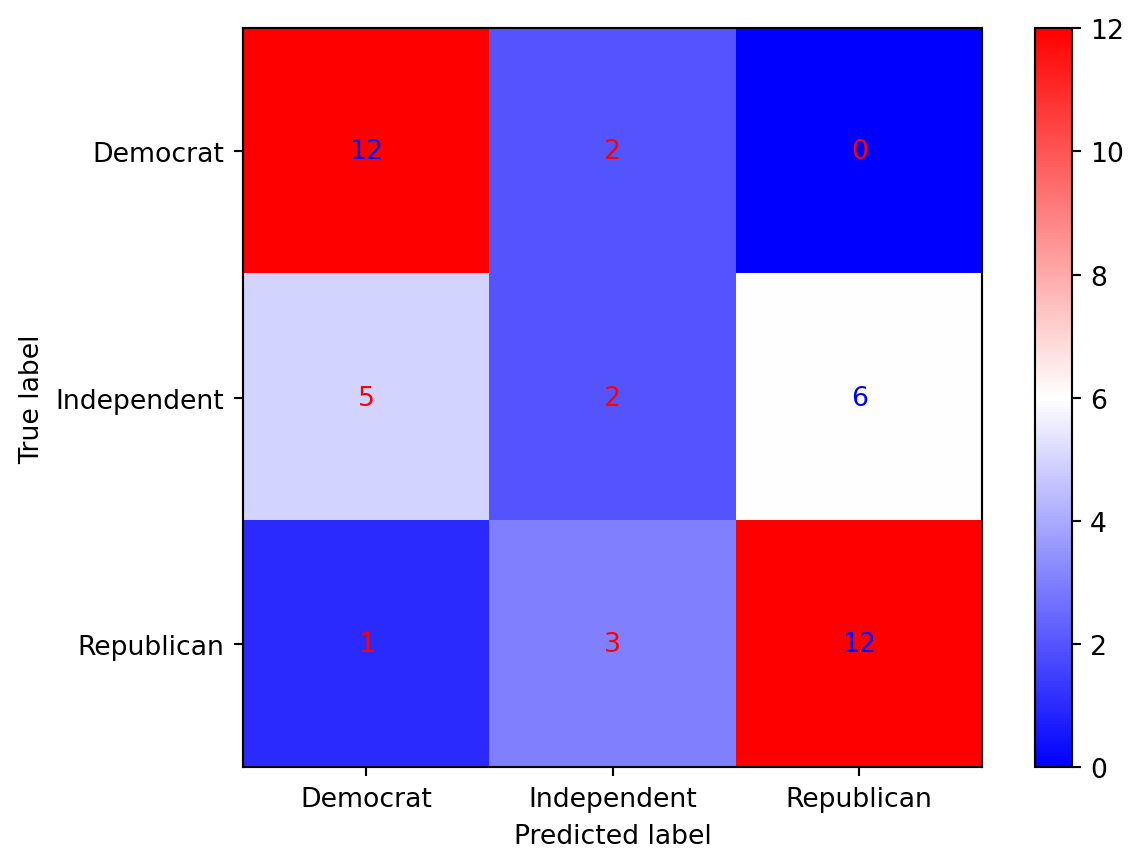

In [27]:
Final_Fit_and_Acc("Final_OVR_log_pipe", "Log", OneVsRestClassifier(
                                                    LogisticRegression(C = 0.15, 
                                                                        penalty="l2",
                                                                        solver="lbfgs")),
                    X_train1, y_train1, X_valid1, y_valid1, Part2_Results)

### 2. SVC 

In [28]:
param_grid_OVR_SVC = {
    "OVR__estimator__C": [0.09, 0.1, 0.15, 0.3, 0.5],
    "OVR__estimator__kernel": ["linear"],
    "OVR__estimator__gamma": ["scale"],
    "OVR__estimator__class_weight": ["balanced"],
}

Build_and_Test_Pipeline("OVR_SVC_Pipe", param_grid_OVR_SVC, "OVR", OneVsRestClassifier(SVC()),
X_train1, y_train1)

                                              params  mean_test_score
0  {'OVR__estimator__C': 0.09, 'OVR__estimator__c...         0.619077
1  {'OVR__estimator__C': 0.1, 'OVR__estimator__cl...         0.642769
2  {'OVR__estimator__C': 0.15, 'OVR__estimator__c...         0.619077
3  {'OVR__estimator__C': 0.3, 'OVR__estimator__cl...         0.611077
4  {'OVR__estimator__C': 0.5, 'OVR__estimator__cl...         0.555077


{'OVR__estimator__C': 0.1,
 'OVR__estimator__class_weight': 'balanced',
 'OVR__estimator__gamma': 'scale',
 'OVR__estimator__kernel': 'linear'}

0.5581395348837209

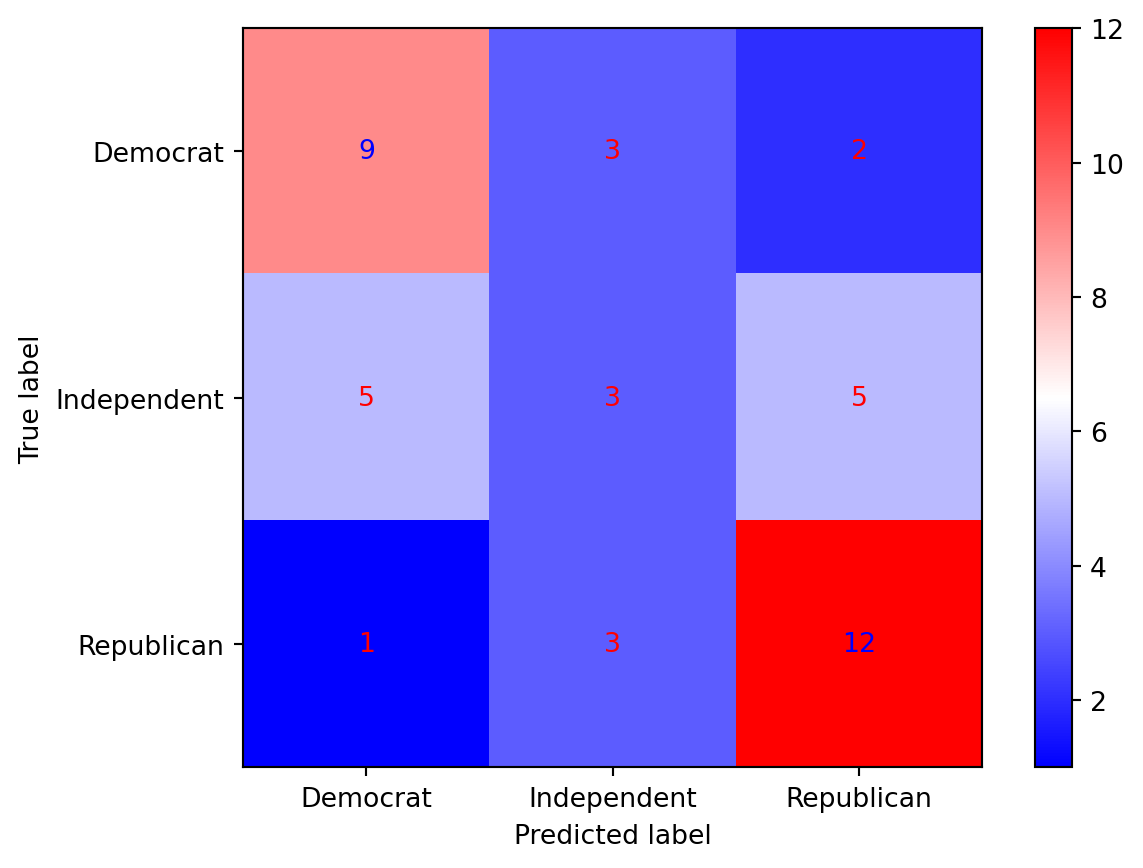

In [29]:
Final_Fit_and_Acc("Final_OVR_SVC", "SVC", OneVsRestClassifier(SVC(C= 0.1, 
                                                              class_weight="balanced", 
                                                              gamma = "scale", 
                                                              kernel= "linear")), 
                    X_train1, y_train1, X_valid1, y_valid1, Part2_Results)

### 3. Results 

In [30]:
df2 = pd.DataFrame(Part2_Results)
df2["Data"] = "OVR"
df2

,Model Name,accuracy,Data
0,Log,0.604651,OVR
1,SVC,0.558140,OVR


## Part Three: OVO Modeling

In [31]:
Part3_Results = []

### 1. Logistic Model

In [32]:
param_grid_log_OVO = {
    "OVO__estimator__C": [0.5, 0.75, 0.80, 0.9, 1],
    "OVO__estimator__solver": ["lbfgs"],
    "OVO__estimator__penalty": ["l2"],
    "OVO__estimator__max_iter": [1000],
}

Build_and_Test_Pipeline("OVO_Log_pipe", param_grid_log_OVO, "OVO", OneVsOneClassifier(LogisticRegression()), 
X_train1, y_train1)

                                              params  mean_test_score
0  {'OVO__estimator__C': 0.5, 'OVO__estimator__ma...         0.618769
1  {'OVO__estimator__C': 0.75, 'OVO__estimator__m...         0.626462
2  {'OVO__estimator__C': 0.8, 'OVO__estimator__ma...         0.626462
3  {'OVO__estimator__C': 0.9, 'OVO__estimator__ma...         0.618462
4  {'OVO__estimator__C': 1, 'OVO__estimator__max_...         0.618462


{'OVO__estimator__C': 0.75,
 'OVO__estimator__max_iter': 1000,
 'OVO__estimator__penalty': 'l2',
 'OVO__estimator__solver': 'lbfgs'}

0.6744186046511628

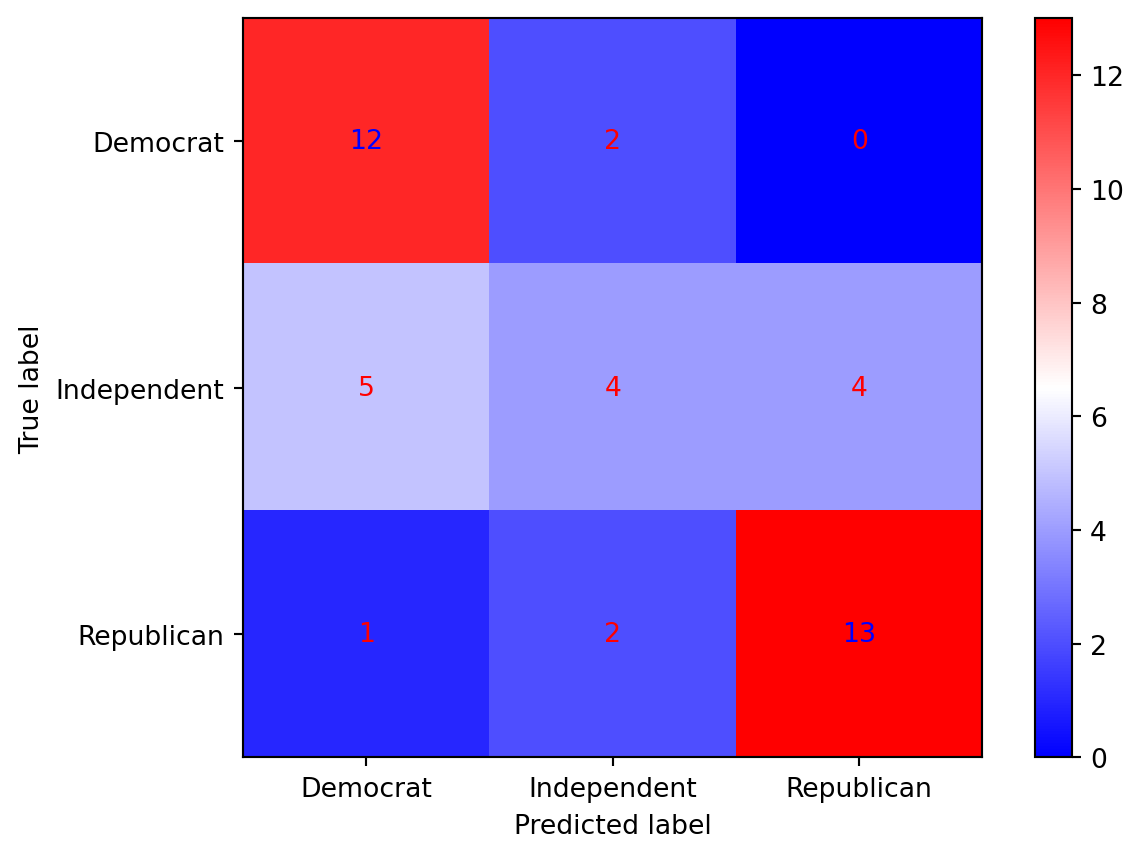

In [33]:
Final_Fit_and_Acc("OVO_LOG_Final", "Log", OneVsOneClassifier(LogisticRegression(
                    C=0.75, 
                    max_iter=1000,
                    penalty="l2",
                    solver="lbfgs"
)), X_train1, y_train1, X_valid1, y_valid1, Part3_Results)

### 2. SVC 

In [34]:
param_grid_OVO_SVC = {
    "OVO__estimator__C": [0.075, 0.09,0.1, 0.2],
    "OVO__estimator__kernel": ["linear", "rbf"],
    "OVO__estimator__gamma": ["scale", "auto"],
    "OVO__estimator__class_weight": [None, "balanced"],
}

Build_and_Test_Pipeline("OVO_SVC_Final", param_grid_OVO_SVC, 
                        "OVO",OneVsOneClassifier(SVC()),X_train1, y_train1 )

                                               params  mean_test_score
0   {'OVO__estimator__C': 0.075, 'OVO__estimator__...         0.626769
1   {'OVO__estimator__C': 0.075, 'OVO__estimator__...         0.357231
2   {'OVO__estimator__C': 0.075, 'OVO__estimator__...         0.626769
3   {'OVO__estimator__C': 0.075, 'OVO__estimator__...         0.357231
4   {'OVO__estimator__C': 0.075, 'OVO__estimator__...         0.618769
5   {'OVO__estimator__C': 0.075, 'OVO__estimator__...         0.453538
6   {'OVO__estimator__C': 0.075, 'OVO__estimator__...         0.618769
7   {'OVO__estimator__C': 0.075, 'OVO__estimator__...         0.437538
8   {'OVO__estimator__C': 0.09, 'OVO__estimator__c...         0.642769
9   {'OVO__estimator__C': 0.09, 'OVO__estimator__c...         0.357231
10  {'OVO__estimator__C': 0.09, 'OVO__estimator__c...         0.642769
11  {'OVO__estimator__C': 0.09, 'OVO__estimator__c...         0.357231
12  {'OVO__estimator__C': 0.09, 'OVO__estimator__c...         0.619077
13  {'

{'OVO__estimator__C': 0.09,
 'OVO__estimator__class_weight': None,
 'OVO__estimator__gamma': 'scale',
 'OVO__estimator__kernel': 'linear'}

0.5813953488372093

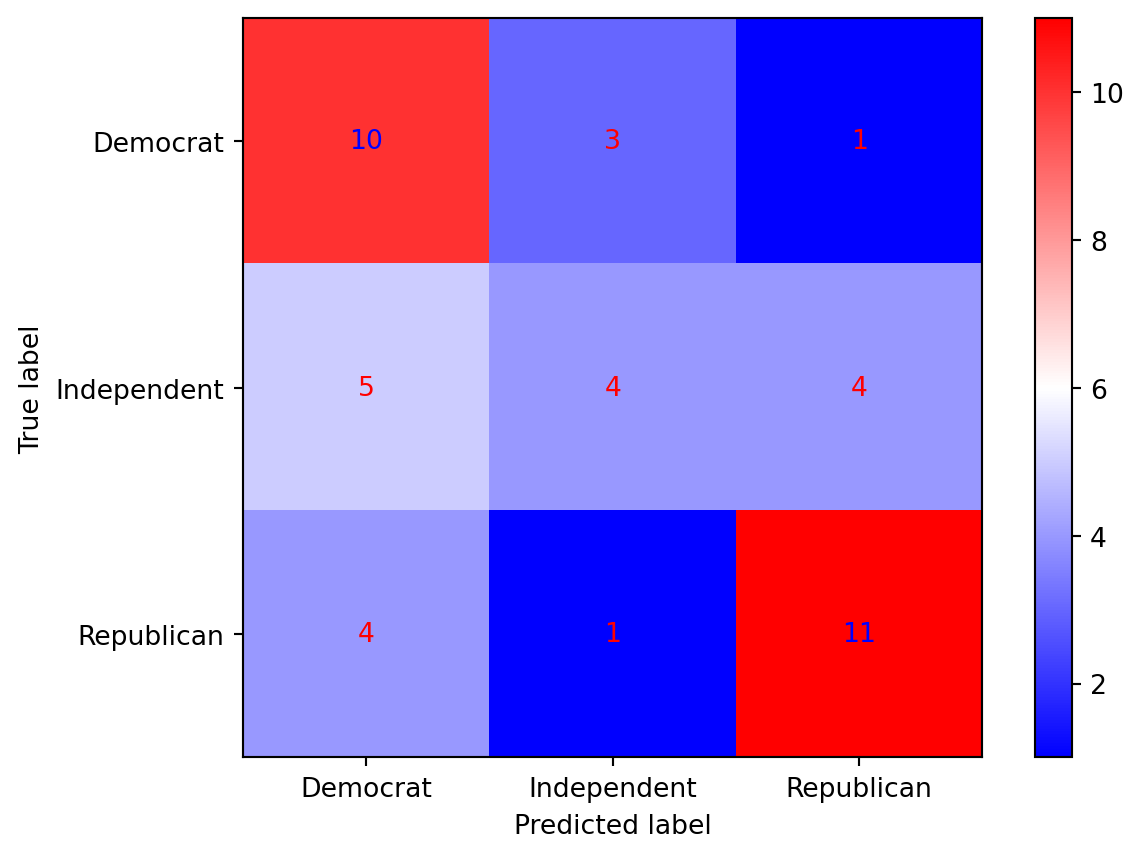

In [35]:
Final_Fit_and_Acc("OVO_SVC_Final", "SVC",OneVsOneClassifier(SVC(C=0.09, 
                                        class_weight=None, 
                                        gamma = "scale", 
                                        kernel = "linear")), 
                                        X_train1, y_train1, X_valid1, y_valid1, Part3_Results)

### 3. Results 

In [36]:
df3 = pd.DataFrame(Part3_Results)
df3["Data"] = "OVO"
df3

,Model Name,accuracy,Data
0,Log,0.674419,OVO
1,SVC,0.581395,OVO


## Part Four: Interpreting Results 

### 1. Data Consolidation

In [37]:
classification_model_scores = pd.concat([df1,df2,df3], ignore_index=True)

classification_model_scores

,Model Name,accuracy,Data
0,Log,0.604651,General
1,LDA,0.581395,General
2,QDA,0.534884,General
3,SVC,0.581395,General
4,KNN,0.534884,General
5,Tree,0.534884,General
6,Log,0.604651,OVR
7,SVC,0.558140,OVR
8,Log,0.674419,OVO
9,SVC,0.581395,OVO


Looking at the above table for classification we can see that our logistic model for ovo performed the best with a predicted accuracy score of .674419, proving that this model had high predictive power. Whats intersting about this model was the training prediction was not as high for the final tuning, indicating that the model accuracy may no be totally correct. We can look at how the model performed compared to our training data below. 

### 2. Prediction Extraction

In [38]:
X_test = CAH_Test.drop("id_num", axis =1)

In [39]:
Final_Pipeline = Pipeline(
    [("Preprocessing", ct), 
     ("OVO_Log",OneVsOneClassifier(LogisticRegression(
                    C=0.75, 
                    max_iter=1000,
                    penalty="l2",
                    solver="lbfgs")))]
    )

Final_Pipeline.fit(X_train1, y_train1)

Pipeline(steps=[('Preprocessing',
                 ColumnTransformer(transformers=[('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x000001390FC3BCB0>),
                                                 ('num', StandardScaler(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x0000013918B951D0>)])),
                ('OVO_Log',
                 OneVsOneClassifier(estimator=LogisticRegression(C=0.75,
                                                                 max_iter=1000)))])

In [40]:
test_pred = Final_Pipeline.predict(X_test)

df_test_plot = CAH_Test.copy()
df_test_plot["political_affiliation"] = test_pred

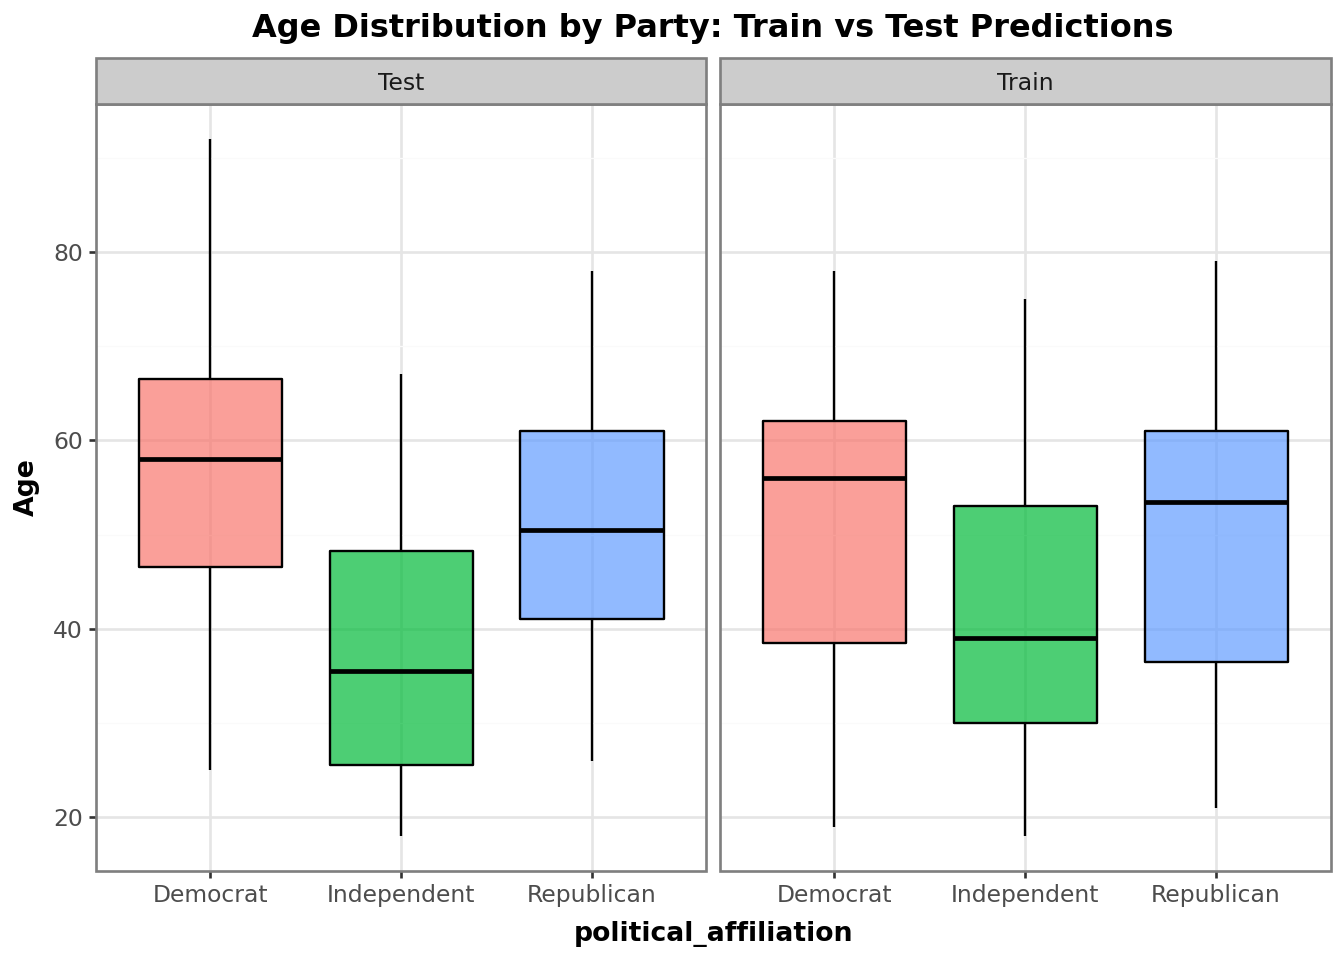

In [41]:
# Stack train (true party) and test (predicted party)
train_long = CAH_Train.assign(
    dataset="Train"
)[["dataset", "political_affiliation", "Q2"]]

test_long = df_test_plot.assign(
    dataset="Test"
)[["dataset", "political_affiliation", "Q2"]]

combined = pd.concat([train_long, test_long], ignore_index=True)

p = (
    p9.ggplot(combined, p9.aes(x="political_affiliation", y="Q2", fill="political_affiliation"))
    + p9.geom_boxplot(alpha=0.7, color="black", outlier_size=2)
    + p9.facet_wrap("~dataset")  # Train panel and Test panel
    + p9.theme_bw()
    + p9.labs(
        title="Age Distribution by Party: Train vs Test Predictions",
        x="political_affiliation",
        y="Age",
        fill="political_affiliation"
    )
    + p9.theme(
        legend_position="none",  # hide legend so plot fills space
        axis_text_x=p9.element_text(rotation=0, ha="center"),
        plot_title=p9.element_text(ha="center", size=12, weight="bold"),
        axis_title_x=p9.element_text(size=10, weight="bold"),
        axis_title_y=p9.element_text(size=10, weight="bold"),
    )
)

p

In [42]:
submission = pd.DataFrame({
    "id_num": CAH_Test["id_num"].values, 
    "political_affiliation_predicted": test_pred
})

submission.to_csv("Lucas_Submission_Class1.csv", index = False)